# Introduction

In this notebook, we aim to predict the price of an Uber fare given minimal initial information. The data can be found on Kaggle at the link <https://www.kaggle.com/datasets/yasserh/uber-fares-dataset/>. 

The focus of this project is meticulous and in-depth feature engineering; after all, a model can only be as good as the data it was trained on. 

# Data Cleaning and Feature Extraction

We begin by loading in and inspecting the dataset.

In [64]:
import pandas as pd

#read in dataset
uber = pd.read_csv('uber_fare_prediction.csv')

#look at first few rows of dataset
uber.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2


In [65]:
#define invalid longitudes and latitudes
pickup_lat_inval = (uber['pickup_latitude'] > 90) | (uber['pickup_latitude'] < -90)
pickup_long_inval = (uber['pickup_longitude'] > 180) | (uber['pickup_longitude'] < -180)
dropoff_lat_inval = (uber['dropoff_latitude'] > 90) | (uber['dropoff_latitude'] < -90)
dropoff_long_inval = (uber['dropoff_longitude'] > 180) | (uber['dropoff_longitude'] < -180)

#count how many invalid rows there are
mask_latlong = (pickup_lat_inval | pickup_long_inval | dropoff_lat_inval | dropoff_long_inval)
mask_latlong.sum()

6

Because there are only $6$ rows with invalid latitude and longitude information, there is no problem with simply removing these rows.

In [66]:
#remove rows with invalid latitude/longitude values
uber = uber[~mask_latlong]

In [67]:
#check for fare amount positive
mask_fare = (uber.fare_amount < 0)
print(mask_fare.sum())

13


In [68]:
#remove the 13 rows with negative fare_amount values
uber = uber[~mask_fare]

In [7]:
import gmaps
import gmplot

#read in Google maps api key
with open('apikey.txt') as f:
    api_key = f.readline()
    f.close
    
gplot = gmplot.GoogleMapPlotter(uber.pickup_latitude.mean(), uber.pickup_longitude. mean(), 6)
gplot.heatmap(uber[0:30000].pickup_latitude , uber[0:30000].pickup_longitude)
gplot.apikey = api_key
gplot.draw('\heatmap.html')

After executing the above code, we obtain the heatmap below. We can see that the Uber rides in this dataset occurred in the New York City metropolitan area.

![Alt Text](heatmap.png)

In [70]:
#look at datatype of each column
uber.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199981 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                199981 non-null  object 
 1   fare_amount        199981 non-null  float64
 2   pickup_datetime    199981 non-null  object 
 3   pickup_longitude   199981 non-null  float64
 4   pickup_latitude    199981 non-null  float64
 5   dropoff_longitude  199980 non-null  float64
 6   dropoff_latitude   199980 non-null  float64
 7   passenger_count    199981 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 13.7+ MB


We will first remove the `key` column, as this is a unique identifier and therefore does not contain useful information. Next, because there are very few non-null values, we will simply drop the rows which contain a null value.

In [71]:
#remove key column
uber = uber.iloc[:, 1:]

#drop rows which contain NA
uber.dropna(axis=0, inplace=True)

We want to extract useful features from the `pickup_datetime` column. To do so, we can first split the column into two features, one containing the date and the other containing the time of day.

In [72]:
#create new pickup_date and pickup_time features
uber[['pickup_date', 'pickup_time', 'garb']] = uber.pickup_datetime.str.split(pat=' ', expand=True)

#drop pickup_datetime column, no longer need it
uber.drop(labels=['pickup_datetime', 'garb'], axis=1, inplace=True)

We now import a new dataset which contains all of the holidays in the United States from 2004-2021, available on Kaggle at <https://www.kaggle.com/datasets/donnetew/us-holiday-dates-2004-2021>. Then, we will perform a left merge with our current dataframe in order to determine which rides occurred on a holiday.

In [73]:
#read in holiday dataset
holiday = pd.read_csv('US Holiday Dates (2004-2021).csv')

#look at first few rows
holiday.head(10)

,Date,Holiday,WeekDay,Month,Day,Year
0,2004-07-04,4th of July,Sunday,7,4,2004
1,2005-07-04,4th of July,Monday,7,4,2005
2,2006-07-04,4th of July,Tuesday,7,4,2006
3,2007-07-04,4th of July,Wednesday,7,4,2007
4,2008-07-04,4th of July,Friday,7,4,2008
5,2009-07-04,4th of July,Saturday,7,4,2009
6,2010-07-04,4th of July,Sunday,7,4,2010
7,2011-07-04,4th of July,Monday,7,4,2011
8,2012-07-04,4th of July,Wednesday,7,4,2012
9,2013-07-04,4th of July,Thursday,7,4,2013


In [74]:
#drop duplicate holidays (i.e. multiple holidays on one day)
holiday.drop_duplicates(subset=['Date'], inplace=True)

In [75]:
#perform left merge, then drop all extraneous columns
uber = pd.merge(left=uber, right=holiday, left_on='pickup_date', right_on='Date', how='left')
uber.drop(labels=['Date', 'WeekDay', 'Month', 'Day', 'Year'], axis=1, inplace=True)

From here, we can simply define a new binary feature which has a value of $1$ whenever the ride occurred on a holiday, and has a value of $0$ otherwise.

In [76]:
import numpy as np

#create binary feature indicating a holiday, then drop the column from the other dataset
uber['holiday'] = np.where(uber['Holiday'].isnull(), 0, 1)
uber = uber.drop(labels=['Holiday'], axis=1)

Our goal now is to extract useful features from the `pickup_date` and `pickup_time` columns. First, we separate out the date into year, month, and day of the month. Then, we can employ the `datetime` library to determine the day of the week for any given date. At the same time, we can discard all the information from `pickup_time` except for the hour, as the minutes and seconds have limited use.

In [78]:
import datetime

#separate pickup_date into three columns
uber[['year', 'month', 'day_of_month']] = uber.pickup_date.str.split(pat='-', expand=True).astype(int)
uber.drop(labels='pickup_date', axis=1, inplace=True)

#create column for day of week using datetime
weekday = lambda row: datetime.date(row['year'], row['month'], row['day_of_month']).isoweekday()
uber['day_of_week'] = uber.apply(weekday, axis=1)

#discard minutes and seconds from pickup_time
uber['time_of_day'] = uber.pickup_time.str.split(pat=':', expand=True).astype(int)[0]
uber.drop(labels='pickup_time', axis=1, inplace=True)

Using the `meteostat` library (documentation available here: <https://dev.meteostat.net/python/>), we can create a new pandas `DataFrame` of weather data for each ride. We will then isolate the columns which are useful to us, and concatenate this `DataFrame` horizontally to the feature set we have been working with thus far. 

In [19]:
from meteostat import Hourly, Point
import warnings
import numpy as np

#meteostat returns warnings if failure instead of errors
warnings.filterwarnings('error')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

#create df of weather data for each ride
weather = []
good_indices = []

for i in range(uber.shape[0]):
    
    row = uber.iloc[i]
    
    #define time (date and hour)
    start = datetime.datetime(int(row.year), 
                              int(row.month), 
                              int(row.day_of_month), 
                              int(row.time_of_day))
    end = start

    #define location
    loc = Point(lat=row.pickup_latitude, lon=row.pickup_longitude)

    #create instance of Hourly class, if warning create row of NaN
    try:
        weather_temp = Hourly(loc, start, end)
        weather_temp = weather_temp.fetch()
    except:
        weather_temp = pd.DataFrame(np.nan, index=[i], columns=['time', 'temp', 'dwpt', 'rhum', 'prcp', 'snow', 
                                                                'wdir', 'wspd', 'wpgt', 'pres', 'tsun', 'coco'])
    
    weather.append(weather_temp)
    
    #verbosely keep track of progress
    if i % 10000 == 0:
        print(f'{i} done')
        
    if len(weather) != i+1:
        print('Error, list didnt get appended to')
        break

warnings.resetwarnings()

0 done
10000 done
20000 done
30000 done
40000 done
50000 done
60000 done
70000 done
80000 done
90000 done
100000 done
110000 done
120000 done
130000 done
140000 done
150000 done
160000 done
170000 done
180000 done
190000 done


In [39]:
#create dataframe of weather data
weather_df = pd.concat(weather, ignore_index=True)
weather_df.shape

(196070, 14)

In [79]:
#create list of indices for which we could retrieve weather data
new_indices = []

for i, w in enumerate(weather):
    new_indices.append(True)
    if w.isnull().values.all().all():
        new_indices[i] = False

In [95]:
#isolate features we want to use from weather_df
weather_useful = weather_df[['temp', 'dwpt', 'rhum', 'wspd']]
weather_useful = weather_useful.dropna().reset_index(drop=True)

In [101]:
#only use rows for which we could retrieve weather data
uber = uber.loc[new_indices].reset_index(drop=True)

In [102]:
#concatenate weather data with rows for which we found weather data
uber = pd.concat([uber2, weather_useful], axis=1)
uber.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,holiday,year,month,day_of_month,day_of_week,time_of_day,temp,dwpt,rhum,wspd
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1,0,2009,6,15,1,17,19.4,13.3,68.0,22.3
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1,0,2010,1,5,2,16,-1.7,-11.8,46.0,33.5
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2,0,2011,8,18,4,0,27.8,17.3,53.0,11.2
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1,0,2012,4,21,6,4,13.9,11.8,87.0,7.6
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1,0,2010,3,9,2,7,8.9,-4.0,40.0,11.2


The time-based features should not be ordinal, because this implies an ordering which is not accurate. So, we implement a one-hot encoding for each of the time variables. Note that we make sure to set the parameter `drop_first=True` in order to avoid perfect collinearity.

In [105]:
#create one-hot encoding for time variables
uber = pd.get_dummies(uber, dtype=float, 
                        columns=['year', 'month', 'day_of_month', 'day_of_week', 'time_of_day'], 
                        drop_first=True).astype(float)

The final step in our data preparation is to extract Euclidean distance between the start and end locations from the latitude and longitude of the two locations via the Haversine formula:
$$
d = 2R\arcsin\left(\sqrt{\sin^2\left(\frac{\phi_2-\phi_1}{2} \right) + \cos\phi_1\cos\phi_2\sin^2\left(\frac{\lambda_2-\lambda_1}{2} \right)} \right),
$$
where $R$ is the radius of the Earth, $\phi$ is latitude, and $\lambda$ is longitude.

In [106]:
import math

#define function for haversine formula
def haversine(lon1, lat1, lon2, lat2):

    R = 6371000  # radius of Earth in meters
    phi_1 = math.radians(lat1)
    phi_2 = math.radians(lat2)

    delta_phi = math.radians(lat2 - lat1)
    delta_lambda = math.radians(lon2 - lon1)

    a = math.sin(delta_phi / 2.0) ** 2 + math.cos(phi_1) * math.cos(phi_2) * math.sin(delta_lambda / 2.0) ** 2
    
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    meters = R * c  # output distance in meters
    return round(meters, 3)

#create feature for euclidean distance
eu_dist = lambda row: haversine(row.pickup_longitude, row.pickup_latitude, row.dropoff_longitude, row.dropoff_latitude)
uber['euclid_dist'] = uber.apply(eu_dist, axis=1)

In [107]:
uber.head()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,holiday,temp,dwpt,rhum,...,time_of_day_15,time_of_day_16,time_of_day_17,time_of_day_18,time_of_day_19,time_of_day_20,time_of_day_21,time_of_day_22,time_of_day_23,euclid_dist
0,4.5,-73.844311,40.721319,-73.841610,40.712278,1.0,0.0,19.4,13.3,68.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1030.764
1,16.9,-74.016048,40.711303,-73.979268,40.782004,1.0,0.0,-1.7,-11.8,46.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8450.134
2,5.7,-73.982738,40.761270,-73.991242,40.750562,2.0,0.0,27.8,17.3,53.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1389.525
3,7.7,-73.987130,40.733143,-73.991567,40.758092,1.0,0.0,13.9,11.8,87.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2799.270
4,5.3,-73.968095,40.768008,-73.956655,40.783762,1.0,0.0,8.9,-4.0,40.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1999.157


# Fitting a Model to the Data

We will fit multiple regression models to the data. First, we perform a $90\%$-$10\%$ train-test split.

In [108]:
from sklearn.model_selection import train_test_split

#separate out features from target
X, y = uber.iloc[:, 1:].values, uber.iloc[:, 0].values

#do 80-20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

First, we fit a linear regression to the training data.

In [110]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#instantiate linear regression object and fit to the training data
slr = LinearRegression()
slr.fit(X_train, y_train)

#evaluate on test data
y_train_pred = slr.predict(X_train)
y_test_pred = slr.predict(X_test)
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)
print(f'MSE train: {mse_train:.4f}')
print(f'MAE train: {mae_train:.4f}')
print(f'R^2 train: {r2_train:.4f}')

MSE train: 73.0133
MAE train: 5.1291
R^2 train: 0.2323


As we can see from the metrics above, the simple linear regression model fails to capture the variance in the training set, and performs even worse on the test set. We will create a residuals plot as well to analyze why the model may be performing so poorly.

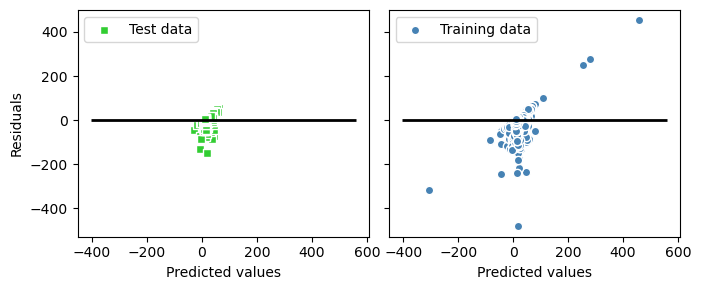

In [111]:
import matplotlib.pyplot as plt

#make residuals plot
x_max = np.max([np.max(y_train_pred), np.max(y_test_pred)])
x_min = np.min([np.min(y_train_pred), np.min(y_test_pred)])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), sharey=True)
ax1.scatter(y_test_pred, y_test_pred - y_test, 
            c='limegreen', marker='s', 
            edgecolor='white', label='Test data')
ax2.scatter(y_train_pred, y_train_pred - y_train, 
            c='steelblue', marker='o', 
            edgecolor='white', label='Training data')
ax1.set_ylabel('Residuals')

for ax in (ax1, ax2):
    ax.set_xlabel('Predicted values')
    ax.legend(loc='upper left')
    ax.hlines(y=0, xmin=x_min-100, xmax=x_max+100, color='black', lw=2)

plt.tight_layout()
plt.show()

Ideally, the residuals would be exactly zero. In a real-world scenario, this will never happen. However, we do expect that, for a successful model, the residuals should be randomly distributed about the centerline. In other words, there should be no discernible pattern in the residuals plot. As we see above, the residuals follow clear patterns, so the linear regression model has failed to capture some of the explanatory information present in the training set.

It's likely that there are nonlinear relationships in the data set that the simple model cannot explain. Below, we fit a random forest regressor, which is much more capable of capturing nonlinearities.

In [122]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

#create parameter grid
param_grid = [{'n_estimators': [100, 300, 500], 
               'max_depth': [3, 5, None], 
               'max_features': ['sqrt', 'log2', 1.0]}]

#create RandomForestRegressor estimator
rfr = RandomForestRegressor(criterion='squared_error', 
                            random_state=42, 
                            n_jobs=-1, 
                            verbose=0)

#create grid search object with RandomForestRegressor classifier
gs = GridSearchCV(estimator=rfr,
                  param_grid=param_grid,
                  scoring='neg_mean_squared_error',
                  refit=True,
                  cv=5, 
                  n_jobs=-1)

#fit it to the training data
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_params_)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:   23.2s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    7.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   27.0s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   22.2s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.0s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.8s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   16.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.4s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.6min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.6min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_

[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   31.3s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.4s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    0.8s
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   21.5s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Do

[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:   12.8s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 430 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.6min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks    

[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   56.5s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   57.6s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   57.5s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.5min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.6min finished
[Pa

[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   21.2s finished
[Parallel(n_jobs=10)]: Done 500 out of 500 | elapsed:   21.5s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.6s
[Para

-18.75770117672968
{'max_depth': None, 'max_features': 1.0, 'n_estimators': 300}


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.7min finished


In [125]:
#predict the test set using the optimal model
y_pred = gs.best_estimator_.predict(X_test)

#print MSE, MAE, and R^2 on test set
print('Metrics on test set')
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'MAE: {mean_absolute_error(y_test, y_pred)}')
print(f'R^2: {r2_score(y_test, y_pred)}')

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    0.8s


Metrics on test set
MSE: 15.046862043074054
MAE: 1.9061548305358578
R^2: 0.8377325153562176


[Parallel(n_jobs=10)]: Done 300 out of 300 | elapsed:    1.3s finished


We can see by the metrics above that the random forest regressor does a much better job of explaining the variance present in the data set. Although it clearly overfits somewhat to the training set, the random forest regressor still achieves an $R^2$ value of $0.8377$ on the test set, which is a massive improvement over the linear regression, which only achieved an $R^2$ value of $0.23$ on the training set.